In [1]:

# Import necessary libraries from previous notebook setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta, date
import os
import random

# Statistical libraries
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Data exploration libraries imported successfully")


Data exploration libraries imported successfully


In [2]:

# Load configuration from previous notebook
PROJECT_FOLDER = "mortgage-credit-risk-modeling"  # Not needed anymore

# Analysis parameters for data generation
DATA_CONFIG = {
    'sample_size': 100000,
    'observation_months': 60,
    'start_date': '2010-01-01',
    'end_date': '2024-12-31',
    'random_seed': 42
}

# File paths for data storage (updated for notebooks/ folder)
DATA_PATHS = {
    'raw_data': '../data/raw/',
    'synthetic_data': '../data/synthetic/',
    'acquisition_file': '../data/raw/acquisition_data.csv',
    'performance_file': '../data/raw/performance_data.csv'
}

print("DATA GENERATION CONFIGURATION")
print(f"Sample Size: {DATA_CONFIG['sample_size']:,} loans")
print(f"Observation Period: {DATA_CONFIG['observation_months']} months")
print(f"Date Range: {DATA_CONFIG['start_date']} to {DATA_CONFIG['end_date']}")
print(f"Data will be saved to: {DATA_PATHS['raw_data']}")


DATA GENERATION CONFIGURATION
Sample Size: 100,000 loans
Observation Period: 60 months
Date Range: 2010-01-01 to 2024-12-31
Data will be saved to: ../data/raw/


In [3]:


# Define realistic parameter distributions for mortgage data generation
# Based on industry data from FHFA, CFPB, and major bank portfolios

# Credit score distribution (approximate U.S. mortgage market)
FICO_DISTRIBUTION = {
    'excellent': (760, 850, 0.30),  # Score range, probability
    'very_good': (700, 759, 0.35),
    'good': (650, 699, 0.25),
    'fair': (600, 649, 0.08),
    'poor': (500, 599, 0.02)
}

# Geographic distribution (top mortgage markets)
STATE_DISTRIBUTION = {
    'CA': 0.12, 'TX': 0.09, 'FL': 0.08, 'NY': 0.06, 'PA': 0.05,
    'IL': 0.04, 'OH': 0.04, 'GA': 0.04, 'NC': 0.04, 'MI': 0.03,
    'NJ': 0.03, 'VA': 0.03, 'WA': 0.03, 'AZ': 0.03, 'MA': 0.02,
    'OTHER': 0.39
}

# Property type distribution
PROPERTY_TYPES = {
    'Single Family': 0.70,
    'Condo': 0.15,
    'Townhouse': 0.10,
    'Multi-Family': 0.03,
    'Manufactured': 0.02
}

# Loan purpose distribution
LOAN_PURPOSES = {
    'Purchase': 0.65,
    'Refinance': 0.30,
    'Cash-Out Refinance': 0.05
}

# Occupancy type distribution
OCCUPANCY_TYPES = {
    'Owner Occupied': 0.85,
    'Investment': 0.10,
    'Second Home': 0.05
}

print("MORTGAGE MARKET PARAMETERS DEFINED")
print(f"Credit Score Categories: {len(FICO_DISTRIBUTION)}")
print(f"Geographic Markets: {len(STATE_DISTRIBUTION)} states/regions")
print(f"Property Types: {len(PROPERTY_TYPES)}")
print(f"Loan Purposes: {len(LOAN_PURPOSES)}")
print("Parameters based on industry data from FHFA, CFPB, and bank portfolios")



MORTGAGE MARKET PARAMETERS DEFINED
Credit Score Categories: 5
Geographic Markets: 16 states/regions
Property Types: 5
Loan Purposes: 3
Parameters based on industry data from FHFA, CFPB, and bank portfolios


In [4]:


# Function to generate realistic credit scores
def generate_credit_scores(n_loans):
    """Generate credit scores following realistic distribution"""
    scores = []
    
    for category, (min_score, max_score, probability) in FICO_DISTRIBUTION.items():
        n_category = int(n_loans * probability)
        # Use normal distribution within each category
        category_mean = (min_score + max_score) / 2
        category_std = (max_score - min_score) / 6
        
        category_scores = np.random.normal(category_mean, category_std, n_category)
        category_scores = np.clip(category_scores, min_score, max_score)
        scores.extend(category_scores)
    
    # Handle rounding differences
    while len(scores) < n_loans:
        scores.append(np.random.randint(600, 800))
    
    return np.array(scores[:n_loans])

# Function to generate incomes correlated with credit scores
def generate_incomes(credit_scores):
    """Generate annual incomes correlated with credit scores"""
    # Base income increases with credit score
    base_income = 40000 + (credit_scores - 500) * 150
    
    # Add log-normal noise to create realistic income distribution
    income_multiplier = np.random.lognormal(0, 0.4, len(credit_scores))
    incomes = base_income * income_multiplier
    
    # Apply realistic bounds
    return np.clip(incomes, 25000, 750000)

# Test the functions with a small sample
test_scores = generate_credit_scores(1000)
test_incomes = generate_incomes(test_scores)

print("DATA GENERATION FUNCTIONS CREATED")
print(f"Test credit scores - Min: {test_scores.min():.0f}, Max: {test_scores.max():.0f}, Mean: {test_scores.mean():.0f}")
print(f"Test incomes - Min: ${test_incomes.min():,.0f}, Max: ${test_incomes.max():,.0f}, Mean: ${test_incomes.mean():,.0f}")
print("Functions ready for full dataset generation")



DATA GENERATION FUNCTIONS CREATED
Test credit scores - Min: 516, Max: 850, Mean: 727
Test incomes - Min: $25,000, Max: $267,627, Mean: $82,458
Functions ready for full dataset generation


In [5]:



# Function to generate property values by state
def generate_property_values(states, n_loans):
    """Generate property values based on state-specific medians"""
    # Approximate median home values by state (2024 data)
    state_medians = {
        'CA': 750000, 'NY': 450000, 'MA': 550000, 'WA': 600000,
        'TX': 300000, 'FL': 350000, 'GA': 250000, 'NC': 280000,
        'PA': 200000, 'IL': 250000, 'OH': 180000, 'MI': 190000,
        'NJ': 400000, 'VA': 350000, 'AZ': 380000, 'OTHER': 275000
    }
    
    values = []
    for state in states:
        median = state_medians.get(state, 275000)
        # Log-normal distribution for property values
        log_median = np.log(median)
        value = np.random.lognormal(log_median, 0.4)
        values.append(max(value, 75000))  # Minimum property value
    
    return np.array(values)

# Function to generate loan amounts based on property values and borrower capacity
def generate_loan_amounts(property_values, incomes, credit_scores):
    """Generate loan amounts considering LTV and DTI constraints"""
    # LTV varies by credit score (higher score = higher allowable LTV)
    base_ltv = 0.60 + (credit_scores - 500) / (850 - 500) * 0.30
    ltv_noise = np.random.normal(0, 0.05, len(property_values))
    actual_ltv = np.clip(base_ltv + ltv_noise, 0.05, 0.95)
    
    # Calculate loan amounts from LTV
    loan_by_ltv = property_values * actual_ltv
    
    # Apply income constraint (typical DTI limit around 43%)
    max_monthly_payment = incomes / 12 * 0.43
    # Approximate loan amount from payment (assume 4% rate, 30 years)
    payment_factor = 0.004774  # Monthly payment per $1000 loan
    max_loan_by_income = max_monthly_payment / payment_factor * 1000
    
    # Take minimum of LTV and income constraints
    loan_amounts = np.minimum(loan_by_ltv, max_loan_by_income)
    
    # Round to nearest $1000
    return np.round(loan_amounts, -3)

# Test property values and loan amounts - FIX THE PROBABILITY ISSUE
# Normalize state distribution probabilities to sum to 1.0
state_probs = np.array(list(STATE_DISTRIBUTION.values()))
state_probs = state_probs / state_probs.sum()  # Normalize to sum to 1.0

test_states = np.random.choice(list(STATE_DISTRIBUTION.keys()), 1000, p=state_probs)
test_property_values = generate_property_values(test_states, 1000)
test_loan_amounts = generate_loan_amounts(test_property_values, test_incomes, test_scores)

print("PROPERTY AND LOAN AMOUNT FUNCTIONS CREATED")
print(f"Test property values - Min: ${test_property_values.min():,.0f}, Max: ${test_property_values.max():,.0f}")
print(f"Test loan amounts - Min: ${test_loan_amounts.min():,.0f}, Max: ${test_loan_amounts.max():,.0f}")
print(f"Test LTV ratio - Mean: {(test_loan_amounts/test_property_values).mean():.2%}")
print(f"State distribution probabilities sum: {state_probs.sum():.3f}")

PROPERTY AND LOAN AMOUNT FUNCTIONS CREATED
Test property values - Min: $75,000, Max: $1,700,739
Test loan amounts - Min: $58,000, Max: $1,472,000
Test LTV ratio - Mean: 79.07%
State distribution probabilities sum: 1.000


In [6]:

# Function to generate origination dates with seasonal patterns
def generate_origination_dates(start_date, end_date, n_loans):
    """Generate origination dates with realistic seasonal patterns"""
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Create seasonal weights (higher volume in spring/summer)
    seasonal_weights = {
        1: 0.07, 2: 0.08, 3: 0.09, 4: 0.10, 5: 0.11, 6: 0.10,
        7: 0.09, 8: 0.08, 9: 0.08, 10: 0.07, 11: 0.06, 12: 0.07
    }
    
    dates = []
    current_date = start
    
    while len(dates) < n_loans and current_date <= end:
        # Determine loans for this month based on seasonal pattern
        month_weight = seasonal_weights[current_date.month]
        base_monthly_loans = n_loans / ((end.year - start.year + 1) * 12)
        monthly_loans = int(base_monthly_loans * month_weight * 12)
        
        # Generate random dates within the month
        days_in_month = (current_date.replace(month=current_date.month % 12 + 1, day=1) - timedelta(days=1)).day
        
        for _ in range(min(monthly_loans, n_loans - len(dates))):
            random_day = random.randint(1, days_in_month)
            loan_date = current_date.replace(day=random_day)
            dates.append(loan_date)
        
        # Move to next month
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1)
    
    # Fill remaining loans if needed
    while len(dates) < n_loans:
        random_date = start + timedelta(days=random.randint(0, (end - start).days))
        dates.append(random_date)
    
    return dates[:n_loans]

# Test origination dates
test_dates = generate_origination_dates(DATA_CONFIG['start_date'], DATA_CONFIG['end_date'], 1000)
test_years = [d.year for d in test_dates]
test_months = [d.month for d in test_dates]

print("ORIGINATION DATE FUNCTION CREATED")
print(f"Date range: {min(test_dates).strftime('%Y-%m-%d')} to {max(test_dates).strftime('%Y-%m-%d')}")
print(f"Years represented: {min(test_years)} to {max(test_years)}")
print(f"Sample seasonal distribution - Spring (Mar-May): {sum(1 for m in test_months if m in [3,4,5])/10:.0f}%")


ORIGINATION DATE FUNCTION CREATED
Date range: 2010-01-01 to 2024-12-18
Years represented: 2010 to 2024
Sample seasonal distribution - Spring (Mar-May): 28%


In [7]:
 

# Function to generate complete acquisition dataset

def generate_acquisition_data(n_loans):
    """Generate complete mortgage acquisition dataset"""
    
    print(f"Generating {n_loans:,} loan acquisition records...")
    
    # Generate loan identifiers
    loan_ids = [f"LOAN_{str(i+1).zfill(8)}" for i in range(n_loans)]
    
    # Generate borrower characteristics
    credit_scores = generate_credit_scores(n_loans)
    incomes = generate_incomes(credit_scores)
    
    # Generate employment types
    employment_types = np.random.choice(
        ['Full-time', 'Part-time', 'Self-employed', 'Contract'],
        n_loans, p=[0.80, 0.05, 0.10, 0.05]
    )
    
    # Generate first-time buyer flags (correlated with credit score)
    ftb_probability = 0.70 - (credit_scores - 500) / (850 - 500) * 0.50
    first_time_buyers = np.random.binomial(1, ftb_probability, n_loans).astype(bool)
    
    # Generate geographic distribution - FIX PROBABILITY ISSUE
    state_probs = np.array(list(STATE_DISTRIBUTION.values()))
    state_probs = state_probs / state_probs.sum()  # Normalize to sum to 1.0
    
    states = np.random.choice(
        list(STATE_DISTRIBUTION.keys()), n_loans, p=state_probs
    )
    
    # Generate property characteristics
    property_values = generate_property_values(states, n_loans)
    property_types = np.random.choice(
        list(PROPERTY_TYPES.keys()), n_loans,
        p=list(PROPERTY_TYPES.values())
    )
    
    # Generate loan characteristics
    loan_amounts = generate_loan_amounts(property_values, incomes, credit_scores)
    loan_to_values = loan_amounts / property_values
    
    # Generate origination dates
    origination_dates = generate_origination_dates(
        DATA_CONFIG['start_date'], DATA_CONFIG['end_date'], n_loans
    )
    
    # Generate loan purposes and occupancy types
    loan_purposes = np.random.choice(
        list(LOAN_PURPOSES.keys()), n_loans,
        p=list(LOAN_PURPOSES.values())
    )
    
    occupancy_types = np.random.choice(
        list(OCCUPANCY_TYPES.keys()), n_loans,
        p=list(OCCUPANCY_TYPES.values())
    )
    
    # Generate loan terms (mostly 30-year fixed)
    loan_terms = np.random.choice([360, 180, 240], n_loans, p=[0.85, 0.10, 0.05])
    
    # Generate product types
    product_types = np.random.choice(
        ['Fixed Rate', 'Adjustable Rate'], n_loans, p=[0.90, 0.10]
    )
    
    print("Generated all acquisition variables successfully")
    return pd.DataFrame({
        'loan_id': loan_ids,
        'origination_date': origination_dates,
        'credit_score': credit_scores.astype(int),
        'annual_income': incomes.astype(int),
        'employment_type': employment_types,
        'first_time_buyer': first_time_buyers,
        'loan_amount': loan_amounts.astype(int),
        'property_value': property_values.astype(int),
        'loan_to_value': loan_to_values.round(4),
        'loan_term': loan_terms,
        'loan_purpose': loan_purposes,
        'product_type': product_types,
        'property_type': property_types,
        'occupancy_type': occupancy_types,
        'state': states
    })

# Generate the acquisition dataset
acquisition_data = generate_acquisition_data(DATA_CONFIG['sample_size'])

print(f"\nACQUISITION DATA GENERATION COMPLETED")
print(f"Dataset shape: {acquisition_data.shape}")
print(f"Memory usage: {acquisition_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Generating 100,000 loan acquisition records...
Generated all acquisition variables successfully

ACQUISITION DATA GENERATION COMPLETED
Dataset shape: (100000, 15)
Memory usage: 44.8 MB


In [8]:

# Display basic acquisition data summary
print("ACQUISITION DATA SUMMARY")
print("=" * 50)

print(f"Total loans generated: {len(acquisition_data):,}")
print(f"Date range: {acquisition_data['origination_date'].min().strftime('%Y-%m-%d')} to {acquisition_data['origination_date'].max().strftime('%Y-%m-%d')}")

print("\nKey Statistics:")
print(f"Credit Score - Mean: {acquisition_data['credit_score'].mean():.0f}, Std: {acquisition_data['credit_score'].std():.0f}")
print(f"Annual Income - Mean: ${acquisition_data['annual_income'].mean():,.0f}, Median: ${acquisition_data['annual_income'].median():,.0f}")
print(f"Loan Amount - Mean: ${acquisition_data['loan_amount'].mean():,.0f}, Median: ${acquisition_data['loan_amount'].median():,.0f}")
print(f"Property Value - Mean: ${acquisition_data['property_value'].mean():,.0f}, Median: ${acquisition_data['property_value'].median():,.0f}")
print(f"LTV Ratio - Mean: {acquisition_data['loan_to_value'].mean():.2%}, Std: {acquisition_data['loan_to_value'].std():.2%}")

print("\nCategorical Distributions:")
print("\nEmployment Type:")
print(acquisition_data['employment_type'].value_counts(normalize=True).round(3))

print("\nProperty Type:")
print(acquisition_data['property_type'].value_counts(normalize=True).round(3))

print("\nLoan Purpose:")
print(acquisition_data['loan_purpose'].value_counts(normalize=True).round(3))

print(f"\nFirst Time Buyers: {acquisition_data['first_time_buyer'].mean():.1%}")


ACQUISITION DATA SUMMARY
Total loans generated: 100,000
Date range: 2010-01-01 to 2024-12-31

Key Statistics:
Credit Score - Mean: 726, Std: 64
Annual Income - Mean: $80,149, Median: $73,453
Loan Amount - Mean: $303,085, Median: $247,000
Property Value - Mean: $381,713, Median: $313,328
LTV Ratio - Mean: 79.39%, Std: 7.36%

Categorical Distributions:

Employment Type:
employment_type
Full-time        0.801
Self-employed    0.099
Contract         0.050
Part-time        0.050
Name: proportion, dtype: float64

Property Type:
property_type
Single Family    0.701
Condo            0.149
Townhouse        0.101
Multi-Family     0.030
Manufactured     0.019
Name: proportion, dtype: float64

Loan Purpose:
loan_purpose
Purchase              0.650
Refinance             0.299
Cash-Out Refinance    0.051
Name: proportion, dtype: float64

First Time Buyers: 37.6%


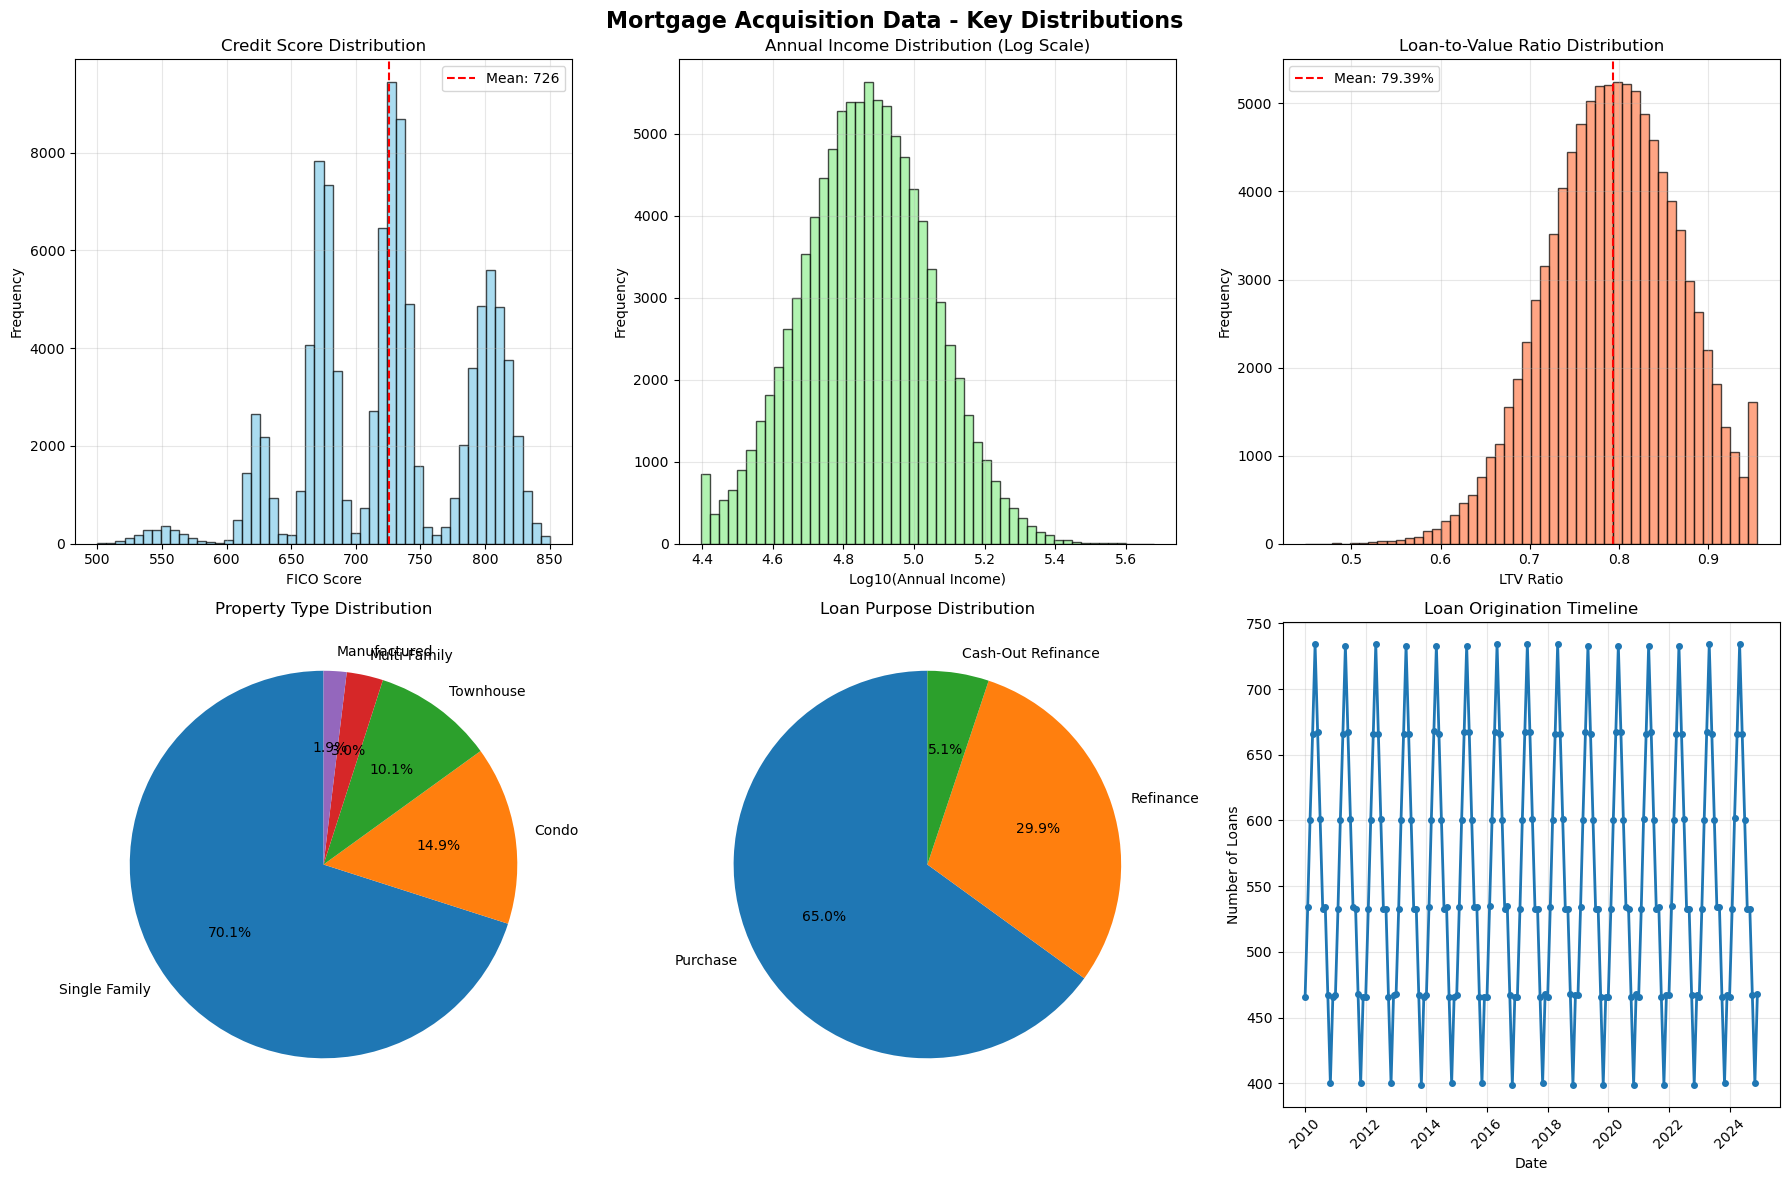

Basic data visualizations completed


In [9]:


# Create basic visualizations of acquisition data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Mortgage Acquisition Data - Key Distributions', fontsize=16, fontweight='bold')

# Credit Score Distribution
axes[0,0].hist(acquisition_data['credit_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(acquisition_data['credit_score'].mean(), color='red', linestyle='--', 
                  label=f'Mean: {acquisition_data["credit_score"].mean():.0f}')
axes[0,0].set_title('Credit Score Distribution')
axes[0,0].set_xlabel('FICO Score')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Annual Income Distribution (log scale)
axes[0,1].hist(np.log10(acquisition_data['annual_income']), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Annual Income Distribution (Log Scale)')
axes[0,1].set_xlabel('Log10(Annual Income)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Loan-to-Value Distribution
axes[0,2].hist(acquisition_data['loan_to_value'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0,2].axvline(acquisition_data['loan_to_value'].mean(), color='red', linestyle='--',
                  label=f'Mean: {acquisition_data["loan_to_value"].mean():.2%}')
axes[0,2].set_title('Loan-to-Value Ratio Distribution')
axes[0,2].set_xlabel('LTV Ratio')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Property Type Distribution
prop_type_counts = acquisition_data['property_type'].value_counts()
axes[1,0].pie(prop_type_counts.values, labels=prop_type_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Property Type Distribution')

# Loan Purpose Distribution
loan_purpose_counts = acquisition_data['loan_purpose'].value_counts()
axes[1,1].pie(loan_purpose_counts.values, labels=loan_purpose_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Loan Purpose Distribution')

# Origination Timeline
monthly_counts = acquisition_data.groupby(acquisition_data['origination_date'].dt.to_period('M')).size()
axes[1,2].plot(monthly_counts.index.to_timestamp(), monthly_counts.values, marker='o', linewidth=2, markersize=4)
axes[1,2].set_title('Loan Origination Timeline')
axes[1,2].set_xlabel('Date')
axes[1,2].set_ylabel('Number of Loans')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Basic data visualizations completed")


In [10]:


# Save acquisition data to file
acquisition_file_path = DATA_PATHS['acquisition_file']

# Ensure directory exists
os.makedirs(os.path.dirname(acquisition_file_path), exist_ok=True)

# Save to CSV
acquisition_data.to_csv(acquisition_file_path, index=False)

print("ACQUISITION DATA SAVED")
print(f"File saved to: {acquisition_file_path}")
print(f"File size: {os.path.getsize(acquisition_file_path) / 1024**2:.1f} MB")

# Verify data integrity
print("\nData Integrity Checks:")
print(f"No missing values: {acquisition_data.isnull().sum().sum() == 0}")
print(f"No duplicate loan IDs: {acquisition_data['loan_id'].nunique() == len(acquisition_data)}")
print(f"LTV ratios within bounds: {(acquisition_data['loan_to_value'] >= 0).all() and (acquisition_data['loan_to_value'] <= 1).all()}")
print(f"Credit scores within range: {(acquisition_data['credit_score'] >= 300).all() and (acquisition_data['credit_score'] <= 850).all()}")

print("\nAcquisition data generation and validation completed successfully")
print("Ready for performance data generation in next section")


ACQUISITION DATA SAVED
File saved to: ../data/raw/acquisition_data.csv
File size: 12.2 MB

Data Integrity Checks:
No missing values: True
No duplicate loan IDs: True
LTV ratios within bounds: True
Credit scores within range: True

Acquisition data generation and validation completed successfully
Ready for performance data generation in next section




```
---

## Performance Data Generation

Now we'll generate monthly performance data for each loan to track payment behavior, delinquencies, and defaults. This is essential for creating the target variable for our credit risk models.

**Performance Data Structure:**
- Monthly records for each loan over 60-month observation period
- Payment status tracking (Current, 30 DPD, 60 DPD, 90+ DPD)
- Default outcomes based on 90+ days past due definition
- Loss calculations for defaulted loans

---
```

In [11]:

# Function to calculate default probability based on loan characteristics
def calculate_default_probability(loan_data):
    """Calculate realistic default probabilities based on loan characteristics"""
    
    # Base default rate varies by credit score (industry curves)
    credit_factor = np.where(loan_data['credit_score'] >= 760, 0.005,  # Super prime
                    np.where(loan_data['credit_score'] >= 720, 0.010,  # Prime+
                    np.where(loan_data['credit_score'] >= 680, 0.020,  # Prime
                    np.where(loan_data['credit_score'] >= 640, 0.040,  # Near prime
                    np.where(loan_data['credit_score'] >= 600, 0.080,  # Subprime
                             0.150)))))                                 # Deep subprime
    
    # LTV adjustment (higher LTV = higher risk)
    ltv_factor = 1 + (loan_data['loan_to_value'] - 0.80) * 2
    ltv_factor = np.clip(ltv_factor, 0.5, 3.0)
    
    # DTI adjustment (calculate estimated DTI)
    estimated_dti = (loan_data['loan_amount'] * 0.004774) / (loan_data['annual_income'] / 12)
    dti_factor = np.where(estimated_dti <= 0.28, 0.8,
                 np.where(estimated_dti <= 0.36, 1.0,
                 np.where(estimated_dti <= 0.43, 1.3, 1.8)))
    
    # Property type adjustment
    prop_type_factor = np.where(loan_data['property_type'] == 'Single Family', 1.0,
                       np.where(loan_data['property_type'] == 'Condo', 1.2,
                       np.where(loan_data['property_type'] == 'Townhouse', 1.1, 1.4)))
    
    # Occupancy adjustment
    occ_factor = np.where(loan_data['occupancy_type'] == 'Owner Occupied', 1.0,
                 np.where(loan_data['occupancy_type'] == 'Investment', 1.5, 1.3))
    
    # Economic environment adjustment
    orig_year = loan_data['origination_date'].dt.year
    econ_factor = np.where(orig_year <= 2012, 1.8,  # Post-crisis
                  np.where(orig_year <= 2019, 0.8,  # Expansion
                  np.where(orig_year <= 2021, 1.4,  # Pandemic
                           1.0)))                     # Normalization
    
    # Combined probability (capped at reasonable levels)
    default_prob = credit_factor * ltv_factor * dti_factor * prop_type_factor * occ_factor * econ_factor
    return np.clip(default_prob, 0.001, 0.200)  # Cap between 0.1% and 20%

# Calculate default probabilities for all loans
print("Calculating default probabilities based on loan characteristics...")
acquisition_data['default_probability'] = calculate_default_probability(acquisition_data)

print("\nDefault Probability Statistics:")
print(f"Mean: {acquisition_data['default_probability'].mean():.3%}")
print(f"Median: {acquisition_data['default_probability'].median():.3%}")
print(f"Min: {acquisition_data['default_probability'].min():.3%}")
print(f"Max: {acquisition_data['default_probability'].max():.3%}")

# Show distribution by credit score bands
credit_bands = pd.cut(acquisition_data['credit_score'], 
                     bins=[0, 580, 620, 660, 700, 740, 780, 850],
                     labels=['<580', '580-619', '620-659', '660-699', '700-739', '740-779', '780+'])

prob_by_band = acquisition_data.groupby(credit_bands)['default_probability'].mean()
print("\nAverage Default Probability by Credit Score Band:")
for band, prob in prob_by_band.items():
    print(f"  {band}: {prob:.3%}")


Calculating default probabilities based on loan characteristics...

Default Probability Statistics:
Mean: 2.537%
Median: 1.187%
Min: 0.231%
Max: 20.000%

Average Default Probability by Credit Score Band:
  <580: 12.035%
  580-619: 7.647%
  620-659: 6.920%
  660-699: 4.258%
  700-739: 1.043%
  740-779: 0.888%
  780+: 0.893%


In [12]:

# Function to generate performance data for individual loan
def generate_loan_performance(loan_record, observation_months=60):
    """Generate monthly performance data for a single loan"""
    
    loan_id = loan_record['loan_id']
    origination_date = loan_record['origination_date']
    default_prob = loan_record['default_probability']
    loan_amount = loan_record['loan_amount']
    
    # Calculate monthly payment
    annual_rate = 0.04  # Simplified - assume 4% for all loans
    monthly_rate = annual_rate / 12
    n_payments = loan_record['loan_term']
    
    if monthly_rate > 0:
        monthly_payment = (loan_amount * (monthly_rate * (1 + monthly_rate)**n_payments) / 
                          ((1 + monthly_rate)**n_payments - 1))
    else:
        monthly_payment = loan_amount / n_payments
    
    # Initialize loan performance tracking
    current_balance = loan_amount
    months_delinquent = 0
    loan_status = 'Active'
    default_month = None
    
    # Determine if/when loan will default
    will_default = np.random.random() < default_prob
    if will_default:
        # Default timing follows hazard curve (more likely in years 2-4)
        hazard_weights = np.concatenate([
            np.linspace(0.5, 1.0, 12),    # Year 1: Lower risk
            np.linspace(1.0, 2.0, 24),   # Years 2-3: Higher risk  
            np.linspace(2.0, 1.5, 24)    # Years 4-5: Declining risk
        ])
        
        if len(hazard_weights) >= observation_months:
            hazard_weights = hazard_weights[:observation_months]
        else:
            # Extend if needed
            hazard_weights = np.concatenate([hazard_weights, 
                                           np.repeat(hazard_weights[-1], 
                                                   observation_months - len(hazard_weights))])
        
        # Normalize to probabilities
        hazard_probs = hazard_weights / hazard_weights.sum() * default_prob * observation_months
        hazard_probs = np.clip(hazard_probs, 0, 0.1)  # Cap monthly probability
        
        # Simulate month of default
        for month in range(observation_months):
            if np.random.random() < hazard_probs[month]:
                default_month = month + 1
                break
    
    # Generate monthly records
    performance_records = []
    
    for month in range(1, observation_months + 1):
        reporting_date = origination_date + pd.DateOffset(months=month)
        
        # Determine payment status for this month
        if loan_status == 'Paid Off' or loan_status == 'Default':
            # Loan already closed
            payment_status = loan_status
            current_payment = 0
        elif default_month and month >= default_month:
            # Loan has defaulted
            if months_delinquent == 0:
                # First month of delinquency
                payment_status = '30 DPD'
                months_delinquent = 1
                current_payment = 0
            elif months_delinquent < 3:
                # Progressing through delinquency
                months_delinquent += 1
                if months_delinquent == 2:
                    payment_status = '60 DPD'
                else:
                    payment_status = '90+ DPD'
                    loan_status = 'Default'
                current_payment = 0
            else:
                # Already in default
                payment_status = 'Default'
                loan_status = 'Default'
                current_payment = 0
        else:
            # Normal payment scenario
            if np.random.random() < 0.02:  # 2% chance of late payment (non-default loans)
                payment_status = '30 DPD'
                current_payment = monthly_payment * 0.5  # Partial payment
            else:
                payment_status = 'Current'
                current_payment = monthly_payment
                months_delinquent = 0
        
        # Update current balance (simplified amortization)
        if payment_status in ['Current', '30 DPD']:
            principal_payment = current_payment - (current_balance * monthly_rate)
            principal_payment = max(0, principal_payment)  # No negative principal
            current_balance = max(0, current_balance - principal_payment)
            
            # Check for payoff
            if current_balance < 100:  # Essentially paid off
                current_balance = 0
                loan_status = 'Paid Off'
                payment_status = 'Paid Off'
        
        # Create performance record
        performance_record = {
            'loan_id': loan_id,
            'reporting_date': reporting_date,
            'months_on_books': month,
            'current_balance': current_balance,
            'payment_status': payment_status,
            'payment_amount': current_payment,
            'months_delinquent': months_delinquent,
            'loan_status': loan_status
        }
        
        performance_records.append(performance_record)
        
        # Stop generating records if loan is paid off or defaulted
        if loan_status in ['Paid Off', 'Default']:
            break
    
    return performance_records

# Test performance generation with a small sample
print("Testing performance data generation...")
test_loan = acquisition_data.iloc[0]
test_performance = generate_loan_performance(test_loan, 24)  # 2 years for testing

print(f"Generated {len(test_performance)} monthly records for test loan")
print(f"Loan status progression: {[record['payment_status'] for record in test_performance[:12]]}")


Testing performance data generation...
Generated 24 monthly records for test loan
Loan status progression: ['Current', 'Current', 'Current', 'Current', 'Current', 'Current', 'Current', 'Current', 'Current', 'Current', 'Current', 'Current']


In [13]:

# Generate complete performance dataset
def generate_complete_performance_data(acquisition_df, observation_months=60, batch_size=1000):
    """Generate performance data for all loans in batches"""
    
    print(f"Generating performance data for {len(acquisition_df):,} loans...")
    print(f"Observation period: {observation_months} months")
    print(f"Processing in batches of {batch_size} loans")
    
    all_performance_records = []
    n_batches = len(acquisition_df) // batch_size + (1 if len(acquisition_df) % batch_size > 0 else 0)
    
    for batch_num in range(n_batches):
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(acquisition_df))
        batch_loans = acquisition_df.iloc[start_idx:end_idx]
        
        print(f"Processing batch {batch_num + 1}/{n_batches} (loans {start_idx:,} to {end_idx:,})")
        
        batch_performance = []
        for _, loan in batch_loans.iterrows():
            loan_performance = generate_loan_performance(loan, observation_months)
            batch_performance.extend(loan_performance)
        
        all_performance_records.extend(batch_performance)
        
        if (batch_num + 1) % 10 == 0:  # Progress update every 10 batches
            print(f"  Completed {batch_num + 1} batches, {len(all_performance_records):,} records generated")
    
    print(f"\nPerformance data generation completed")
    print(f"Total performance records: {len(all_performance_records):,}")
    
    return pd.DataFrame(all_performance_records)

# Generate performance data for all loans
performance_data = generate_complete_performance_data(
    acquisition_data, 
    observation_months=DATA_CONFIG['observation_months'], 
    batch_size=1000
)

print(f"\nPERFORMANCE DATA SUMMARY")
print(f"Total records: {len(performance_data):,}")
print(f"Unique loans: {performance_data['loan_id'].nunique():,}")
print(f"Date range: {performance_data['reporting_date'].min().date()} to {performance_data['reporting_date'].max().date()}")
print(f"Memory usage: {performance_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


Generating performance data for 100,000 loans...
Observation period: 60 months
Processing in batches of 1000 loans
Processing batch 1/100 (loans 0 to 1,000)
Processing batch 2/100 (loans 1,000 to 2,000)
Processing batch 3/100 (loans 2,000 to 3,000)
Processing batch 4/100 (loans 3,000 to 4,000)
Processing batch 5/100 (loans 4,000 to 5,000)
Processing batch 6/100 (loans 5,000 to 6,000)
Processing batch 7/100 (loans 6,000 to 7,000)
Processing batch 8/100 (loans 7,000 to 8,000)
Processing batch 9/100 (loans 8,000 to 9,000)
Processing batch 10/100 (loans 9,000 to 10,000)
  Completed 10 batches, 598,293 records generated
Processing batch 11/100 (loans 10,000 to 11,000)
Processing batch 12/100 (loans 11,000 to 12,000)
Processing batch 13/100 (loans 12,000 to 13,000)
Processing batch 14/100 (loans 13,000 to 14,000)
Processing batch 15/100 (loans 14,000 to 15,000)
Processing batch 16/100 (loans 15,000 to 16,000)
Processing batch 17/100 (loans 16,000 to 17,000)
Processing batch 18/100 (loans 17,

In [14]:
 


# Analyze performance data and default outcomes
print("PERFORMANCE DATA ANALYSIS")
print("=" * 50)

# Payment status distribution
print("\n1. PAYMENT STATUS DISTRIBUTION")
status_dist = performance_data['payment_status'].value_counts(normalize=True)
for status, pct in status_dist.items():
    print(f"  {status}: {pct:.1%}")

# Default analysis
print("\n2. DEFAULT ANALYSIS")

# Identify defaulted loans (ever had 90+ DPD status)
defaulted_loans = performance_data[
    performance_data['payment_status'].isin(['90+ DPD', 'Default'])
]['loan_id'].unique()

default_rate = len(defaulted_loans) / acquisition_data['loan_id'].nunique()
print(f"Total loans that defaulted: {len(defaulted_loans):,}")
print(f"Portfolio default rate: {default_rate:.2%}")

# Time to default analysis
default_timing = performance_data[
    performance_data['loan_id'].isin(defaulted_loans) & 
    (performance_data['payment_status'] == '90+ DPD')
].groupby('loan_id')['months_on_books'].min()

print(f"Average time to default: {default_timing.mean():.1f} months")
print(f"Median time to default: {default_timing.median():.1f} months")

# Default rate by credit score bands
acquisition_with_default = acquisition_data.copy()
acquisition_with_default['defaulted'] = acquisition_with_default['loan_id'].isin(defaulted_loans)

credit_bands = pd.cut(acquisition_with_default['credit_score'], 
                     bins=[0, 580, 620, 660, 700, 740, 780, 850],
                     labels=['<580', '580-619', '620-659', '660-699', '700-739', '740-779', '780+'])

default_by_band = acquisition_with_default.groupby(credit_bands)['defaulted'].agg(['count', 'sum', 'mean'])
default_by_band['default_rate'] = default_by_band['mean']

print(f"\n3. DEFAULT RATES BY CREDIT SCORE BAND")
for band in default_by_band.index:
    count = default_by_band.loc[band, 'count']
    defaults = default_by_band.loc[band, 'sum']
    rate = default_by_band.loc[band, 'default_rate']
    print(f"  {band}: {defaults:,}/{count:,} ({rate:.2%})")

# Loan status summary
print(f"\n4. FINAL LOAN STATUS SUMMARY")
final_status = performance_data.groupby('loan_id')['loan_status'].last().value_counts()
for status, count in final_status.items():
    pct = count / len(acquisition_data)
    print(f"  {status}: {count:,} ({pct:.1%})")



PERFORMANCE DATA ANALYSIS

1. PAYMENT STATUS DISTRIBUTION
  Current: 97.9%
  30 DPD: 2.0%
  60 DPD: 0.0%
  90+ DPD: 0.0%

2. DEFAULT ANALYSIS
Total loans that defaulted: 2,145
Portfolio default rate: 2.15%
Average time to default: 23.1 months
Median time to default: 21.0 months

3. DEFAULT RATES BY CREDIT SCORE BAND
  <580: 232/1,948 (11.91%)
  580-619: 213/2,728 (7.81%)
  620-659: 421/6,552 (6.43%)
  660-699: 937/23,839 (3.93%)
  700-739: 180/30,681 (0.59%)
  740-779: 23/5,862 (0.39%)
  780+: 139/28,390 (0.49%)

4. FINAL LOAN STATUS SUMMARY
  Active: 97,855 (97.9%)
  Default: 2,145 (2.1%)


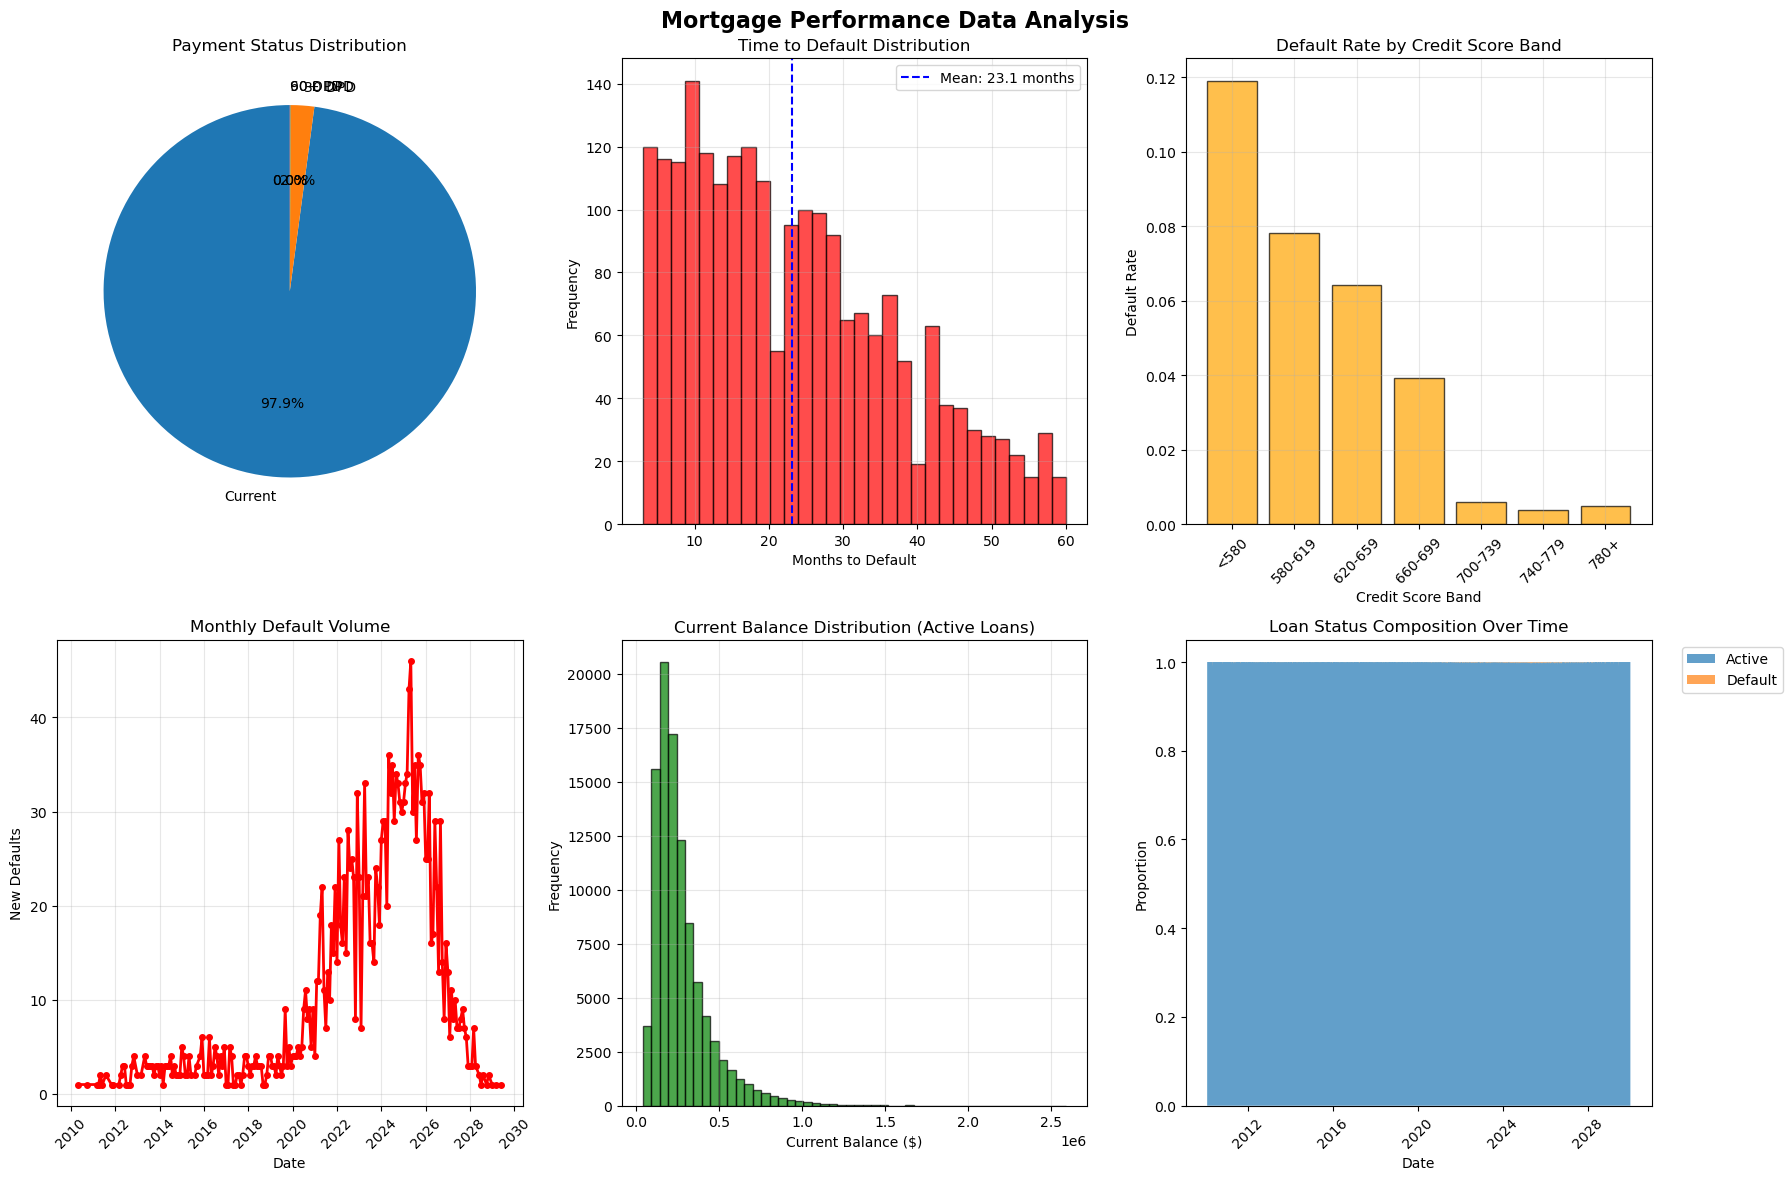

Performance data visualizations completed


In [15]:
 
# Create performance data visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Mortgage Performance Data Analysis', fontsize=16, fontweight='bold')

# 1. Payment Status Distribution
status_counts = performance_data['payment_status'].value_counts()
axes[0,0].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Payment Status Distribution')

# 2. Default Timeline (Time to Default)
default_timing = performance_data[
    performance_data['loan_id'].isin(defaulted_loans) & 
    (performance_data['payment_status'] == '90+ DPD')
].groupby('loan_id')['months_on_books'].min()

axes[0,1].hist(default_timing, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0,1].axvline(default_timing.mean(), color='blue', linestyle='--', 
                  label=f'Mean: {default_timing.mean():.1f} months')
axes[0,1].set_title('Time to Default Distribution')
axes[0,1].set_xlabel('Months to Default')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Default Rates by Credit Score
default_by_band.reset_index(inplace=True)
axes[0,2].bar(range(len(default_by_band)), default_by_band['default_rate'], 
              alpha=0.7, color='orange', edgecolor='black')
axes[0,2].set_title('Default Rate by Credit Score Band')
axes[0,2].set_xlabel('Credit Score Band')
axes[0,2].set_ylabel('Default Rate')
axes[0,2].set_xticks(range(len(default_by_band)))
axes[0,2].set_xticklabels(default_by_band['credit_score'], rotation=45)
axes[0,2].grid(True, alpha=0.3)

# 4. Monthly Default Volume
monthly_defaults = performance_data[
    performance_data['payment_status'] == '90+ DPD'
].groupby(performance_data['reporting_date'].dt.to_period('M')).size()

axes[1,0].plot(monthly_defaults.index.to_timestamp(), monthly_defaults.values, 
               marker='o', linewidth=2, markersize=4, color='red')
axes[1,0].set_title('Monthly Default Volume')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('New Defaults')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 5. Current Balance Distribution for Active Loans
active_performance = performance_data[performance_data['loan_status'] == 'Active']
current_balances = active_performance.groupby('loan_id')['current_balance'].last()

axes[1,1].hist(current_balances[current_balances > 0], bins=50, alpha=0.7, 
               color='green', edgecolor='black')
axes[1,1].set_title('Current Balance Distribution (Active Loans)')
axes[1,1].set_xlabel('Current Balance ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

# 6. Loan Status Over Time
status_over_time = performance_data.groupby(['reporting_date', 'loan_status']).size().unstack(fill_value=0)
status_over_time_pct = status_over_time.div(status_over_time.sum(axis=1), axis=0)

axes[1,2].stackplot(status_over_time_pct.index, 
                    *[status_over_time_pct[col] for col in status_over_time_pct.columns],
                    labels=status_over_time_pct.columns, alpha=0.7)
axes[1,2].set_title('Loan Status Composition Over Time')
axes[1,2].set_xlabel('Date')
axes[1,2].set_ylabel('Proportion')
axes[1,2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Performance data visualizations completed")


In [17]:


# Save performance data and create default target variable
print("SAVING PERFORMANCE DATA AND CREATING TARGET VARIABLE")
print("=" * 60)

# 1. Save complete performance data
performance_file_path = DATA_PATHS['performance_file']
performance_data.to_csv(performance_file_path, index=False)

print(f"Performance data saved to: {performance_file_path}")
print(f"File size: {os.path.getsize(performance_file_path) / 1024**2:.1f} MB")

# 2. Create loan-level target variable for modeling
print(f"\nCreating loan-level target variable...")

# Define default as ever reaching 90+ DPD
loan_defaults = performance_data[
    performance_data['payment_status'].isin(['90+ DPD', 'Default'])
]['loan_id'].unique()

# Create target variable dataset
target_data = acquisition_data[['loan_id']].copy()
target_data['default_flag'] = target_data['loan_id'].isin(loan_defaults).astype(int)

# Add time to default for defaulted loans
time_to_default = performance_data[
    performance_data['loan_id'].isin(loan_defaults) & 
    (performance_data['payment_status'] == '90+ DPD')
].groupby('loan_id')['months_on_books'].min()

target_data['months_to_default'] = target_data['loan_id'].map(time_to_default)

# Add final loan status
final_status = performance_data.groupby('loan_id')['loan_status'].last()
target_data['final_status'] = target_data['loan_id'].map(final_status)

# Calculate loss given default (simplified)
defaulted_loans_balance = performance_data[
    (performance_data['loan_id'].isin(loan_defaults)) &
    (performance_data['payment_status'] == '90+ DPD')
].groupby('loan_id')['current_balance'].first()

original_amounts = acquisition_data.set_index('loan_id')['loan_amount']
target_data['loss_given_default'] = target_data['loan_id'].map(
    lambda x: defaulted_loans_balance.get(x, 0) / original_amounts.get(x, 1) if x in loan_defaults else 0
)

# Save target variable data
target_file_path = '../data/processed/target_variables.csv'
os.makedirs('../data/processed', exist_ok=True)
target_data.to_csv(target_file_path, index=False)

print(f"Target variables saved to: {target_file_path}")

# Summary statistics
print(f"\nTARGET VARIABLE SUMMARY")
print(f"Total loans: {len(target_data):,}")
print(f"Defaulted loans: {target_data['default_flag'].sum():,}")
print(f"Default rate: {target_data['default_flag'].mean():.2%}")
print(f"Average months to default: {target_data[target_data['default_flag']==1]['months_to_default'].mean():.1f}")
print(f"Average loss given default: {target_data[target_data['default_flag']==1]['loss_given_default'].mean():.1%}")

print(f"\nFinal Status Distribution:")
for status, count in target_data['final_status'].value_counts().items():
    pct = count / len(target_data)
    print(f"  {status}: {count:,} ({pct:.1%})")

print(f"\nData generation completed successfully!")
print(f"Ready for data cleaning and preprocessing in Notebook 03")


SAVING PERFORMANCE DATA AND CREATING TARGET VARIABLE
Performance data saved to: ../data/raw/performance_data.csv
File size: 461.2 MB

Creating loan-level target variable...
Target variables saved to: ../data/processed/target_variables.csv

TARGET VARIABLE SUMMARY
Total loans: 100,000
Defaulted loans: 2,145
Default rate: 2.15%
Average months to default: 23.1
Average loss given default: 96.4%

Final Status Distribution:
  Active: 97,855 (97.9%)
  Default: 2,145 (2.1%)

Data generation completed successfully!
Ready for data cleaning and preprocessing in Notebook 03
